# GD4. 뉴스 카테고리 다중 분류

## 필요한 모듈 import

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score # 정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 로드
* ```num_words```: 빈도수 기준 상위 몇 번째까지 사용할 것인지
* ```test_split```: 데이터 중 어느 정도 비율을 테스트 셋으로 나눌 것인지

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

# 데이터 출력해보면 숫자 시퀀스가 출력됨 (텐서플로우에서 이미 전처리한 데이터 제공)
print(x_train[0])
print(x_test[0])

# 각 뉴스는 정수로 된 레이블을 가지고 있음
print(y_train[0])
print(y_test[0])

# 전체 클래스 수 (= 레이블 수) 확인
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510,

## 데이터 분포 확인
* 3번 (3159개), 4번 (1949개) 클래스가 대부분이고 19번, 16번, 1번, 11번 등이 뒤를 이음 

훈련용 뉴스의 최대 길이: 2376
훈련용 뉴스의 평균 길이: 145.5398574927633


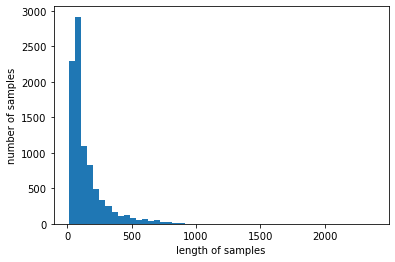

In [3]:
print('훈련용 뉴스의 최대 길이: {}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이: {}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

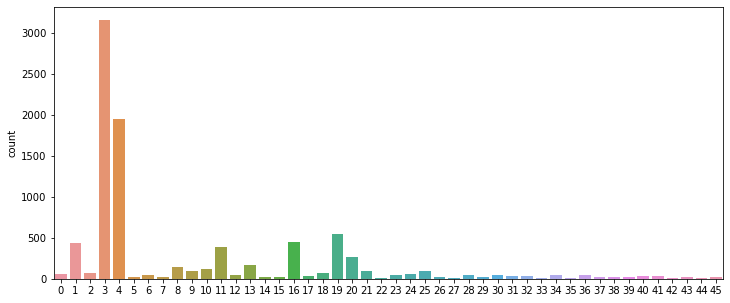

In [4]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(12,5)
sns.countplot(y_train)

## 원본 뉴스 데이터로 복원해보기
* 단어를 key로, 정수 인덱스 값을 value로 제공하는 dict를 텍스트로 돌려보기

In [5]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [6]:
print(word_index['the']) # 'the' 의 인덱스는 1
print(word_index['it']) # 'it' 의 인덱스는 13

1
13


In [7]:
# index_to_word (정수 -> 단어) 만들기
# 로이터 뉴스 데이터는 +3 이라는 규칙을 가지고 있음: 0, 1, 2번은 각각 <pad>, <sos>, <unk>

index_to_word = {index + 3 : word for word, index in word_index.items()}
print(index_to_word[4]) # 'the'
print(index_to_word[16]) # 'it'

the
it


In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

In [9]:
# index_to_word 를 이용해 훈련용 뉴스 기사 하나를 원래 텍스트로 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


## OOV 문제와 UNK 토큰
* ```load_data()```시 설정한 ```num_words=10000``` 은 정수 번호 10000번 이상의 단어들을 모두 \<unk\> 토큰으로 처리
* OOV (out-of-vocabulary): 기계가 미처 배우지 못한 모르는 단어가 등장한 경우, 그 단어를 OOV라고 한다. 해당 단어는 모두 \<unk\> 로 표현된다

In [10]:
# [4, 587, 23, 133, 6, 30, 515] 라는 정수 시퀀스가 있다면,
print(' '.join([index_to_word[index] for index in [4, 587, 23, 133, 6, 30, 515]])) # the transaction is expected to be completed

# 그렇다면, [4, 12000, 23, 133, 6, 30, 515] 라는 정수 시퀀스가 있다면?
print(' '.join([index_to_word[index] for index in [4, 12000, 23, 133, 6, 30, 515]])) # 12000이 OOV에 해당하므로 [4, 1, 23, 133, 6, 30, 515] 로 변환되어 데이터가 로드됨

the transaction is expected to be completed
the staffing is expected to be completed


In [11]:
# 훈련용 뉴스 데이터 전체, 테스트용 뉴스 데이터 전체를 텍스트로 변환
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

print(x_train[:5])
print(x_test[:5])

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3', '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3', '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for one

## 벡터화하기
* 텍스트 데이터를 모델의 입력으로 넣기 위해서는 벡터화가 필요
* 다양한 벡터화 방법: Word Embedding, Document Embedding, Contextual Embedding 등
* 이 실습에서는 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬을 사용
* DTM 기반 문서 군집/분류 https://wikidocs.net/24559
    - DTM (document-term matrix): 열은 단어, 행은 문서
    - 열의 개수는 단어 수에서 중복을 제외한 수
    - 불용어가 성능 저하의 요인이 될 수 있음
* TF-IDF: DTM의 단점을 보완 https://wikidocs.net/31698
    - 모든 문서에 걸쳐 자주 등장하는 단어는 중요도가 낮은 단어 (불용어 등) 로 판단

In [12]:
dtm_vector = CountVectorizer()
x_train_dtm = dtm_vector.fit_transform(x_train)
print(x_train_dtm.shape) # (8982, 9670)

(8982, 9670)


In [13]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape) # (8982, 9670)

(8982, 9670)


## 나이브 베이즈 분류기
* https://www.youtube.com/watch?v=3JWLIV3NaoQ
    - 조건부 확률: 독립인 경우 P(A|B) = P(A), P(B|A) = P(B) / 독립이 아닌 경우 P(A∩B) = P(A)P(B|A)
    - 베이즈 정리
        - P(A|B) = P(A∩B) / P(B)
        - P(A∩B) = P(A|B)P(B)
        - P(B∩A) = P(B|A)P(A)
        - P(B∩A) = P(A∩B)
        - P(A∩B) = P(B|A)P(A) = P(A|B)P(B)
        - P(B|A)P(A) = P(A|B)P(B)
        - **P(B|A) = P(A|B)P(B) / P(A)**
* scikit-learn의 ```MultinomialNB()```

In [14]:
mod = MultinomialNB()
mod.fit(tfidfv, y_train)

MultinomialNB()

In [15]:
# 테스트 데이터도 TF-IDF 행렬로 변환 (정확도 측정을 위해 훈련 데이터와 동일한 전처리)
x_test_dtm = dtm_vector.transform(x_test) # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교 (정확도: 0.6567230632235085)

정확도: 0.6567230632235085


In [16]:
# 테스트
print(x_test[3], '\n') # 원문
print(y_test[3]) # 레이블

<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3 

4


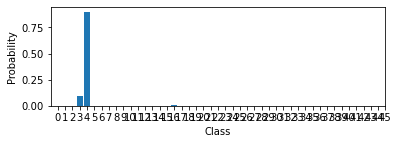

In [17]:
# 위 3번 데이터를 정확하게 예측하는지 확인
plt.subplot(211)
plt.rcParams["figure.figsize"] = (10,10)
plt.bar(mod.classes_, mod.predict_proba(tfidfv_test[3])[0])
plt.xlim(-1, 21)
plt.xticks(mod.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show() # 90% 확률로 4로 예측. 정확하게 예측함을 확인

In [18]:
mod.predict(tfidfv_test[3])

array([4])

## F1-score, Confusion Matrix
* 분류성능평가지표: https://sumniya.tistory.com/26
    - Precision (정밀도): 모델이 True라고 분류한 것 중 실제 True인 것의 비율. *(Precision) = TP / (TP+FP)*
    - Recall (재현율): 실제 True인 것 중 모델이 True라고 예측한 것의 비율. *(Recall) = TP / (TP+FN)*
    - Accuracy (정확도): True인 것을 True라고 예측했거나, False인 것을 False라고 예측한 경우 *(Accuracy) = (TP+TN) / (TP+FN+FP+TN)*
    - F1-score: Precision과 Recall의 조화평균. 레이블이 불균형 (편중 (bias) 되어 있는) 인 경우 정확도가 떨어지는 것을 보완하기 위한 지표
* scikit-learn의 ```metrics``` 패키지에서 제공하는 ```classification_report()```
    - macro avg: 단순평균
    - weighted avg: 각 클래스에 속하는 표본의 수로 가중평균
    - accuracy: 정확도. 전체 학습 데이터의 수에서 클래스를 정확하게 맞춘 수의 비율
* Confusion Matrix: https://www.youtube.com/watch?v=M0GBAzFV9_A, https://mjdeeplearning.tistory.com/31

<참고>
* TP : True로 예측하고 실제 값도 True
* TN : False로 예측하고 실제 값도 False
* FP : True로 예측하고 실제는 False
* FN : False로 예측하고 실제는 True

In [19]:
print(classification_report(y_test, mod.predict(tfidfv_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


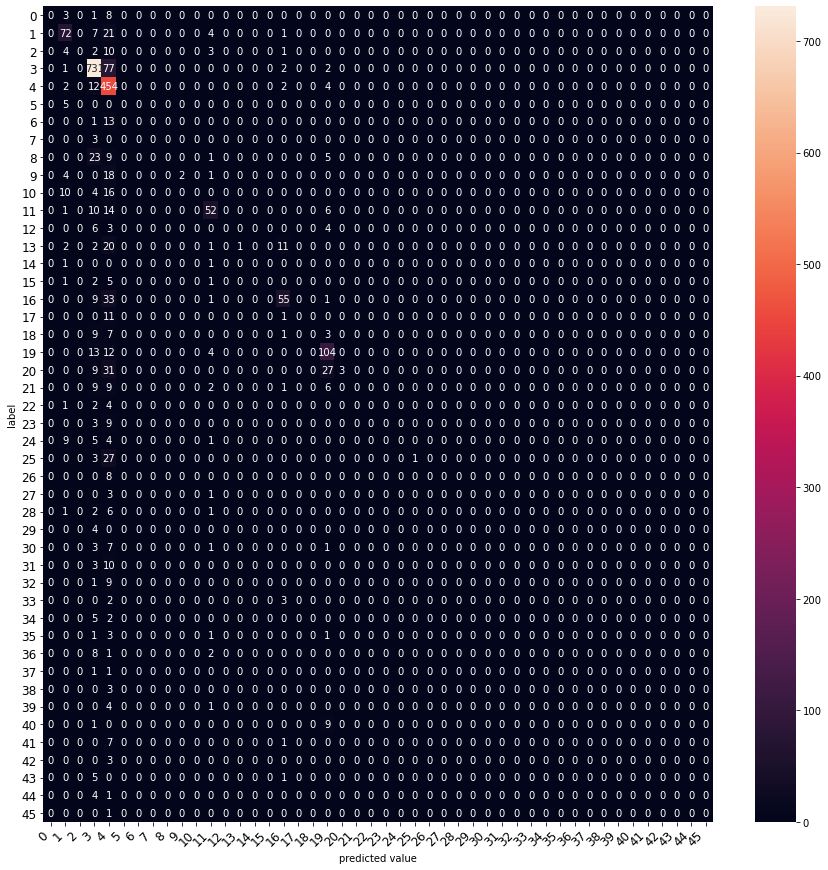

In [20]:
# confusion matrix (혼동 행렬) 시각화
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    
graph_confusion_matrix(mod, tfidfv_test, y_test)

## 다양한 머신 러닝 모델 사용해보기

### CNB (Complement Naive Bayes Classifier)
* 컴플리먼트 나이브 베이즈 분류기: 나이브 베이즈 분류기의 단점 (샘플이 불균형할 경우 결정 경계의 가중치가 한쪽으로 치우쳐져 특정 클래스를 선호할 수 있음) 을 보완하기 위해 데이터의 불균형을 고려해 가중치를 부여하는 방식
* MultinomialNB보다 성능이 일반적으로 더 좋다

In [21]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.7707034728406055


### 로지스틱 회귀 (Logistic Regression)
* 소프트맥스 (softmax) 함수를 사용한 다중 클래스 분류 알고리즘 지원
    - 소프트맥스 함수: 클래스가 N개일 때, N차원의 벡터가 각 클래스가 정답일 확률을 표현하도록 정규화해주는 함수
    - scikit-learn의 ```LogisticRegression()```

In [22]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.8076580587711487


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 선형 서포트 벡터 머신
* https://www.youtube.com/watch?v=y4CYcpRiNsw
* desicion boundary 와 가장 가까이 있는 데이터의 거리 (margin) 가 너무 가까우면 분류가 잘못될 수 있다
* Support Vector란 decision boundary와 가장 가까이 있는 각 클래스의 데이터를 뜻한다
* scikit-learn의 ```LinearSVC()```
* 기본적으로 이진 분류를 위한 모델이지만, 일대다 (one- vs. -rest 또는 one- vs. -all) 방식으로 다중 클래스 분류 알고리즘으로 사용 가능

In [23]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.7707034728406055


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### 결정 트리 (Decision Tree)
* 결정에 다다르기 위해 예/아니오 질문을 이어나가면서 학습하는 방식 (스무고개와 같은 방식)
* Supervised Learning Model 중 하나
* https://www.youtube.com/watch?v=n0p0120Gxqk

In [24]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.6202137132680321


### 랜덤 포레스트 (Random Forest)
* https://www.youtube.com/watch?v=nZB37IBCiSA
    - 여러 개의 결정 트리로 구성된 분류기. 투표를 통해 하나의 결정을 내린다
    - 결정 트리는 모든 데이터를 학습에 사용하는 반면 랜덤 포레스트는 트리 별로 일부 데이터만 사용해 학습
    - boosing: 중복 데이터를 허용해 모델의 bias가 올라가게 됨 
    - 결정 트리의 단점 (오버피팅 가능성 높음) -> 랜덤 포레스트는 이 문제를 앙상블로 해결. 가령, 서로 다른 방향으로 과적합된 트리들을 조합하면 오히려 모델 전체에서는 과적합을 피할 수 있다
    - 가장 좋은 질문을 가장 먼저 하는 결정 트리와 다르게, 질문이 randomly seleted된 게 랜덤 포레스트의 특징

In [25]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.674087266251113


### 그래디언트 부스팅 트리 (GradientBoostingClassifier)
* 여러 개의 결정 트리를 묶어 만드는 앙상블 모델
* 랜덤 포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리 만듬
* 일부 특성을 무시하는 특징을 가지고 있음 -> 보통 랜덤 포레스트를 먼저 사용해보고, 성능이나 예측 시간 면에서 만족스럽지 않은 경우 시도해보는 것이 좋음
* 1~5 정도의 깊지 않은 트리를 사용하기 때문에 메모리 사용량이 적고 예측도 빠름

In [26]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.7666963490650045


### 보팅 (Voting)
* https://www.youtube.com/watch?v=y4Wh0E1d4oE
    - 앙상블 기법 중 하나
    - 앙상블: 모델들이 함께 결과를 도출하도록 하여, 개개 모델이 가진 성능보다 더 나은 성능을 발휘하도록 하는 방법
    - 하드 보팅: 각 모델에게 투표권을 하나씩 주고, 최종 값을 다수결로 투표해 결정
    - 소프트 보팅: confidence value를 사용해, 모든 confidence value의 평균으로 가장 높은 결과를 선정

In [27]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 예측값과 실제값 비교

정확도: 0.8116651825467498


## 프로젝트: vocabulary size를 변경해서 시도해보기

### 모든 단어 사용

In [28]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

index_to_word = {index + 3 : word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token
    
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

dtm_vector = CountVectorizer()
x_train_dtm = dtm_vector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)
(8982, 26506)


In [29]:
# 나이브 베이즈 분류기

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

# 테스트 데이터도 TF-IDF 행렬로 변환 (정확도 측정을 위해 훈련 데이터와 동일한 전처리)
x_test_dtm = dtm_vector.transform(x_test) # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.5997328584149599 

F1 score (macro): 0.06767886443611608
F1 score (micro): 0.5997328584149599
F1 score (weighted): 0.5045670886188423 

F1 scores: [0.         0.33082707 0.         0.81189189 0.60869565 0.
 0.         0.         0.         0.         0.         0.42477876
 0.         0.         0.         0.         0.29268293 0.
 0.         0.64435146 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [30]:
# CNB

cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.7649154051647373 

F1 score (macro): 0.4639854358945848
F1 score (micro): 0.7649154051647373
F1 score (weighted): 0.7346534179503126 

F1 scores: [0.63157895 0.73015873 0.64516129 0.89116055 0.82986767 0.
 0.88888889 0.8        0.13333333 0.84615385 0.83018868 0.60540541
 0.         0.57971014 0.         0.18181818 0.71361502 0.
 0.59459459 0.65230769 0.36363636 0.69565217 0.         0.52631579
 0.17391304 0.7037037  0.93333333 0.         0.15384615 0.
 0.         0.47058824 0.88888889 0.88888889 0.83333333 0.28571429
 0.         0.         0.5        0.33333333 0.         0.36363636
 0.5        0.28571429 0.88888889 1.        ]


In [31]:
# 로지스틱 회귀

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.813446126447017 

F1 score (macro): 0.669532685925375
F1 score (micro): 0.813446126447017
F1 score (weighted): 0.8079349566211766 

F1 scores: [0.76190476 0.77419355 0.7        0.92892157 0.83890578 0.33333333
 0.96551724 0.8        0.69230769 0.84615385 0.89655172 0.69714286
 0.4        0.61333333 0.8        0.625      0.73786408 0.57142857
 0.7027027  0.69402985 0.53543307 0.70967742 0.         0.72
 0.57142857 0.82142857 0.93333333 0.4        0.42857143 0.72727273
 0.76190476 0.57142857 0.88888889 0.8        0.44444444 0.5
 0.43478261 0.5        0.4        0.44444444 0.46153846 0.71428571
 1.         0.92307692 0.72727273 1.        ]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [32]:
# 서포트 벡터 머신

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.7818343722172751 

F1 score (macro): 0.607413602892518
F1 score (micro): 0.7818343722172753
F1 score (weighted): 0.776378152173332 

F1 scores: [0.72727273 0.70588235 0.66666667 0.9170252  0.82976555 0.
 0.92857143 0.5        0.63414634 0.875      0.81355932 0.65517241
 0.3        0.52941176 0.5        0.66666667 0.66046512 0.26666667
 0.66666667 0.63272727 0.51162791 0.66666667 0.22222222 0.69565217
 0.48484848 0.71186441 0.875      0.66666667 0.42857143 0.54545455
 0.47058824 0.6        0.88888889 0.8        0.72727273 0.5
 0.31578947 0.8        0.5        0.54545455 0.28571429 0.42857143
 0.57142857 0.92307692 0.8        0.5       ]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
# 결정 트리

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.6211041852181657 

F1 score (macro): 0.15450055404800783
F1 score (micro): 0.6211041852181657
F1 score (weighted): 0.5769283128518846 

F1 scores: [0.         0.52941176 0.5625     0.8896062  0.54866101 0.
 0.         0.         0.         0.27586207 0.84210526 0.59171598
 0.         0.         0.         0.         0.7008547  0.
 0.         0.5046729  0.13157895 0.         0.         0.
 0.18181818 0.29268293 0.         0.         0.16666667 0.
 0.         0.         0.         0.88888889 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [34]:
# 랜덤 포레스트

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.6544968833481746 

F1 score (macro): 0.2794631711818573
F1 score (micro): 0.6544968833481746
F1 score (weighted): 0.6225909375608356 

F1 scores: [0.35       0.44366197 0.35555556 0.85126396 0.70956211 0.
 0.52173913 0.4        0.49315068 0.4375     0.27906977 0.59887006
 0.22222222 0.21818182 0.         0.         0.51977401 0.
 0.27586207 0.54771784 0.4        0.31578947 0.         0.13333333
 0.09090909 0.36842105 0.         0.         0.         0.
 0.         0.         0.18181818 0.57142857 0.         0.28571429
 0.33333333 0.         0.         0.         0.46153846 0.
 0.         0.6        0.88888889 1.        ]


In [35]:
# 그래디언트 부스팅 트리

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.7702582368655387 

F1 score (macro): 0.572792648567258
F1 score (micro): 0.7702582368655387
F1 score (weighted): 0.7641672650539437 

F1 scores: [0.54545455 0.75757576 0.63636364 0.89195678 0.82046138 0.33333333
 0.74074074 0.5        0.61538462 0.85106383 0.77966102 0.62790698
 0.48       0.38709677 0.         0.15384615 0.71428571 0.55555556
 0.54054054 0.67460317 0.50434783 0.61818182 0.2        0.64
 0.5625     0.72727273 1.         0.4        0.22222222 0.54545455
 0.38461538 0.51851852 1.         0.90909091 0.5        0.22222222
 0.56       0.66666667 0.33333333 0.25       0.625      0.625
 0.8        0.46153846 0.8        0.66666667]


In [36]:
# 보팅

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.8187889581478184 

F1 score (macro): 0.6577141879659247
F1 score (micro): 0.8187889581478184
F1 score (weighted): 0.8147231278247327 

F1 scores: [0.75       0.78640777 0.72727273 0.93154034 0.84928717 0.33333333
 0.89655172 0.5        0.7012987  0.8        0.9        0.69005848
 0.52173913 0.66666667 0.44444444 0.28571429 0.74257426 0.6
 0.62857143 0.70943396 0.56910569 0.70967742 0.25       0.64
 0.64705882 0.84210526 1.         0.57142857 0.31578947 0.66666667
 0.56       0.75       1.         0.90909091 0.66666667 0.5
 0.58333333 0.5        0.4        0.22222222 0.57142857 0.61538462
 1.         0.83333333 0.8        0.66666667]


### 상위 5000개만 사용

In [37]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

index_to_word = {index + 3 : word for word, index in word_index.items()}

for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token
    
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded

dtm_vector = CountVectorizer()
x_train_dtm = dtm_vector.fit_transform(x_train)
print(x_train_dtm.shape)

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)
(8982, 4867)


In [38]:
# 나이브 베이즈 분류기

mod = MultinomialNB()
mod.fit(tfidfv, y_train)

# 테스트 데이터도 TF-IDF 행렬로 변환 (정확도 측정을 위해 훈련 데이터와 동일한 전처리)
x_test_dtm = dtm_vector.transform(x_test) # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM을 TF-IDF 행렬로 변환

predicted = mod.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.6731967943009796 

F1 score (macro): 0.11017286132336847
F1 score (micro): 0.6731967943009796
F1 score (weighted): 0.6012501291711391 

F1 scores: [0.         0.61764706 0.         0.87061669 0.72859451 0.
 0.         0.         0.         0.4375     0.         0.57819905
 0.         0.23809524 0.         0.         0.625      0.
 0.         0.62608696 0.225      0.         0.         0.
 0.         0.12121212 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [39]:
# CNB

cb = ComplementNB()
cb.fit(tfidfv, y_train)

predicted = cb.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.7707034728406055 

F1 score (macro): 0.48203488372044917
F1 score (micro): 0.7707034728406055
F1 score (weighted): 0.7458990404916549 

F1 scores: [0.7        0.72580645 0.64516129 0.90230243 0.81945744 0.
 0.85714286 0.8        0.30769231 0.86792453 0.87272727 0.63316583
 0.         0.63768116 0.         0.         0.72222222 0.
 0.57142857 0.65838509 0.46464646 0.72       0.         0.44444444
 0.18181818 0.81355932 0.875      0.4        0.25       0.
 0.         0.26666667 0.82352941 0.88888889 0.83333333 0.28571429
 0.         0.66666667 0.5        0.         0.         0.36363636
 0.5        0.28571429 0.88888889 1.        ]


In [40]:
# 로지스틱 회귀

lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

predicted = lr.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.8058771148708815 

F1 score (macro): 0.6427529674429183
F1 score (micro): 0.8058771148708815
F1 score (weighted): 0.7994583667437475 

F1 scores: [0.76190476 0.78504673 0.79069767 0.9223301  0.83877551 0.
 0.88888889 0.8        0.68292683 0.84615385 0.89655172 0.68156425
 0.4        0.63013699 0.5        0.66666667 0.69565217 0.7826087
 0.68571429 0.67407407 0.53225806 0.68852459 0.         0.52173913
 0.62857143 0.75471698 0.93333333 0.4        0.5        0.6
 0.58823529 0.60869565 0.88888889 0.8        0.44444444 0.5
 0.31578947 0.5        0.4        0.4        0.42857143 0.71428571
 0.8        0.8        0.88888889 1.        ]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
# 서포트 벡터 머신

lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

predicted = lsvc.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.7689225289403384 

F1 score (macro): 0.5771871588089644
F1 score (micro): 0.7689225289403384
F1 score (weighted): 0.7646444225570777 

F1 scores: [0.72727273 0.67592593 0.75555556 0.89798412 0.82045929 0.
 0.85714286 0.5        0.64197531 0.80769231 0.74193548 0.67836257
 0.48       0.58227848 0.4        0.47058824 0.6763285  0.47058824
 0.62857143 0.6259542  0.5        0.67647059 0.         0.58333333
 0.52941176 0.66666667 0.93333333 0.66666667 0.22222222 0.25
 0.63636364 0.53846154 0.73684211 0.8        0.57142857 0.44444444
 0.44444444 0.4        0.5        0.25       0.44444444 0.57142857
 0.33333333 0.85714286 0.88888889 0.66666667]


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
# 결정 트리

tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.6179875333926982 

F1 score (macro): 0.17794649395239356
F1 score (micro): 0.6179875333926982
F1 score (weighted): 0.5729970881280324 

F1 scores: [0.         0.51533742 0.51428571 0.88541667 0.54684512 0.
 0.72727273 0.         0.         0.88       0.86666667 0.54054054
 0.10526316 0.         0.         0.         0.6893617  0.
 0.         0.37037037 0.05263158 0.         0.         0.
 0.1        0.31578947 0.         0.         0.16666667 0.
 0.         0.         0.         0.90909091 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [43]:
# 랜덤 포레스트

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

predicted = forest.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.701246660730187 

F1 score (macro): 0.35960899933378104
F1 score (micro): 0.701246660730187
F1 score (weighted): 0.6770217603524399 

F1 scores: [0.33333333 0.54849498 0.38888889 0.86925373 0.75189394 0.
 0.57142857 0.5        0.55555556 0.51282051 0.66666667 0.62295082
 0.21052632 0.38095238 0.         0.2        0.68393782 0.
 0.51428571 0.62962963 0.38333333 0.5        0.         0.375
 0.09090909 0.56521739 0.22222222 0.4        0.         0.28571429
 0.         0.         0.46153846 0.33333333 0.         0.28571429
 0.14285714 0.66666667 0.         0.         0.33333333 0.16666667
 0.         0.5        0.88888889 1.        ]


In [44]:
# 그래디언트 부스팅 트리

grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

predicted = grbt.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.767586821015138 

F1 score (macro): 0.5791898381470704
F1 score (micro): 0.767586821015138
F1 score (weighted): 0.7662475269931749 

F1 scores: [0.76190476 0.73195876 0.7        0.89895897 0.79074447 0.16666667
 0.92857143 0.4        0.64935065 0.875      0.86666667 0.63953488
 0.46153846 0.48484848 0.14285714 0.26666667 0.74509804 0.33333333
 0.57894737 0.6796875  0.496      0.66666667 0.22222222 0.38461538
 0.66666667 0.75471698 0.75       0.44444444 0.33333333 0.30769231
 0.4        0.52173913 0.77777778 0.83333333 0.36363636 0.66666667
 0.6        0.8        0.28571429 0.22222222 0.58823529 0.47058824
 0.85714286 0.57142857 0.88888889 0.66666667]


In [45]:
# 보팅

voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

predicted = voting_classifier.predict(tfidfv_test) # 테스트 데이터에 대한 예측

print("정확도:", accuracy_score(y_test, predicted), '\n') # 예측값과 실제값 비교
print("F1 score (macro):", f1_score(y_test, predicted, average='macro'))
print("F1 score (micro):", f1_score(y_test, predicted, average='micro'))
print("F1 score (weighted):", f1_score(y_test, predicted, average='weighted'), '\n')
print("F1 scores:", f1_score(y_test, predicted, average=None))

정확도: 0.8161175422974176 

F1 score (macro): 0.6642429726937643
F1 score (micro): 0.8161175422974176
F1 score (weighted): 0.8126712904613167 

F1 scores: [0.81818182 0.78640777 0.77272727 0.92848485 0.84780388 0.25
 0.92857143 0.66666667 0.7027027  0.82352941 0.91525424 0.68235294
 0.52173913 0.64788732 0.2        0.53333333 0.73737374 0.61538462
 0.68421053 0.70817121 0.53968254 0.71186441 0.22222222 0.61538462
 0.68571429 0.83636364 0.875      0.57142857 0.42105263 0.6
 0.5        0.72       0.88888889 0.83333333 0.6        0.66666667
 0.45454545 0.8        0.4        0.22222222 0.53333333 0.57142857
 0.85714286 0.76923077 0.88888889 1.        ]


### 최적 모델과 딥러닝 모델 비교

In [46]:
from tensorflow import keras

(x_train_compare, y_train_compare), (x_test_compare, y_test_compare) = reuters.load_data()

total_data_text = list(x_train_compare) + list(x_test_compare)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균: ', np.mean(num_tokens))
print('문장길이 최대: ', np.max(num_tokens))
print('문장길이 표준편차: ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('maxlen of pad_sequences: ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. \n'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

x_train_compare = keras.preprocessing.sequence.pad_sequences(x_train_compare, padding='pre', maxlen=maxlen) # value=0 (default)
x_test_compare = keras.preprocessing.sequence.pad_sequences(x_test_compare, padding='pre', maxlen=maxlen) # value=0 (default)

vocab_size = 50000  # 어휘 사전의 크기입니다
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim)) # , input_shape=(None,)))
model.add(keras.layers.LSTM(100))
model.add(keras.layers.Dense(46, activation='softmax'))

model.summary()

문장길이 평균:  145.96419665122906
문장길이 최대:  2376
문장길이 표준편차:  145.8784764459447
maxlen of pad_sequences:  437
전체 문장의 0.9438902743142145%가 maxlen 설정값 이내에 포함됩니다. 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 46)                4646      
Total params: 10,125,046
Trainable params: 10,125,046
Non-trainable params: 0
_________________________________________________________________


In [47]:
# https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221226716255
from tensorflow.keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [48]:
x_val = x_train_compare[:3000]
y_val = y_train_compare[:3000]

partial_x_train_compare = x_train_compare[3000:]
partial_y_train_compare = y_train_compare[3000:]

partial_y_train_compare = keras.utils.to_categorical(partial_y_train_compare)
y_val = keras.utils.to_categorical(y_val)
y_test_compare = keras.utils.to_categorical(y_test_compare)

'''
print(partial_x_train_compare.shape)
print(partial_y_train_compare.shape)
print(x_val.shape)
print(y_val.shape)

print(partial_x_train_compare[0])
print(partial_y_train_compare[0])
print(x_val[0])
print(y_val[0])
'''

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# 학습 시작
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])


epochs = 20

history = model.fit(partial_x_train_compare, partial_y_train_compare, epochs=epochs, batch_size=32, validation_data=(x_val, y_val), verbose=1, callbacks=[es])

Epoch 1/20
187/187 [==============================] - 17s 89ms/step - loss: 2.2994 - accuracy: 0.4254 - precision: 0.5693 - recall: 0.1667 - f1score: 0.2518 - val_loss: 2.0431 - val_accuracy: 0.4970 - val_precision: 0.9451 - val_recall: 0.2778 - val_f1score: 0.4238
Epoch 2/20
187/187 [==============================] - 16s 87ms/step - loss: 1.8418 - accuracy: 0.5264 - precision: 0.9022 - recall: 0.3913 - f1score: 0.5348 - val_loss: 1.7773 - val_accuracy: 0.5543 - val_precision: 0.8131 - val_recall: 0.4921 - val_f1score: 0.6102
Epoch 3/20
187/187 [==============================] - 17s 88ms/step - loss: 1.6526 - accuracy: 0.5794 - precision: 0.8904 - recall: 0.5052 - f1score: 0.6396 - val_loss: 1.8320 - val_accuracy: 0.5630 - val_precision: 0.8160 - val_recall: 0.4955 - val_f1score: 0.6136
Epoch 4/20
187/187 [==============================] - 17s 89ms/step - loss: 1.4790 - accuracy: 0.6301 - precision: 0.9147 - recall: 0.5271 - f1score: 0.6653 - val_loss: 1.6078 - val_accuracy: 0.6097 - v

In [49]:
# 테스트 셋으로 평가
_loss, _acc, _precision, _recall, _f1score = model.evaluate(x_test_compare, y_test_compare, verbose=2)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

71/71 - 1s - loss: 1.5673 - accuracy: 0.6434 - precision: 0.8151 - recall: 0.5767 - f1score: 0.6733
loss: 1.567, accuracy: 0.643, precision: 0.815, recall: 0.577, f1score: 0.673


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1score'])


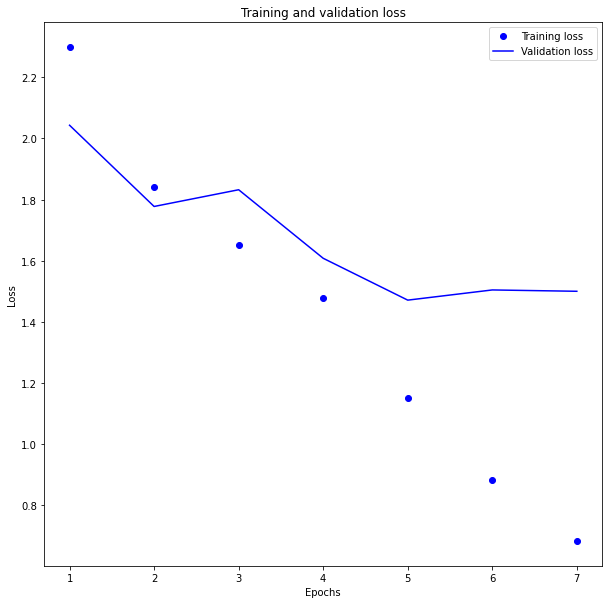

In [50]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# training and validation loss

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

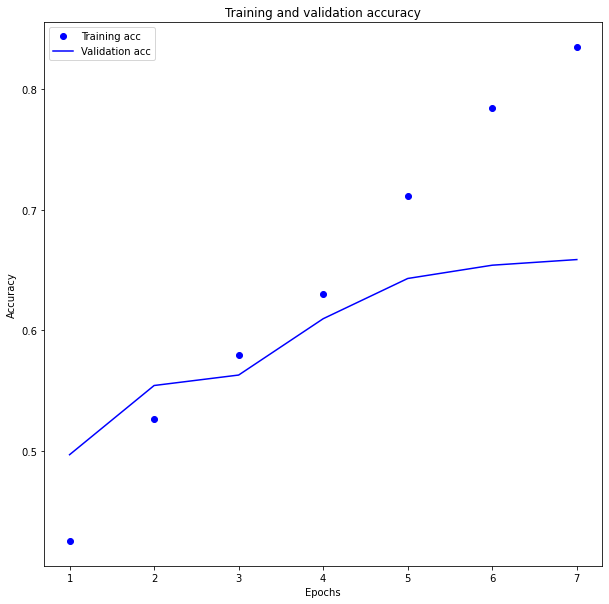

In [51]:
plt.clf() # 그림을 초기화합니다

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

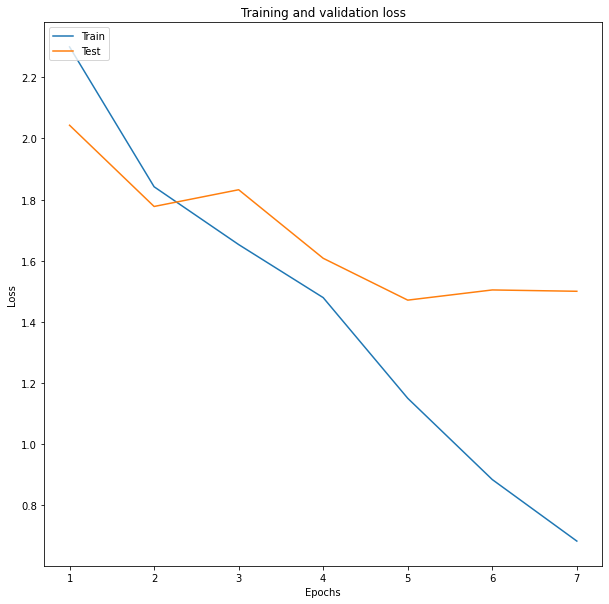

In [52]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()